# Visualisation of the MIMIC data using t-SNE

For a background on t-Distributed Stochastic Neighbor Embedding (t-SNE), see Laurens van der Maaten's blog: https://lvdmaaten.github.io/tsne/


In [ ]:
# config
# for speed, run on a subset of patient
run_on_subset = True
# should the proportion of each class be equalized?
balanceclasses = False 
# Random state. prev 354235
randomstate = 9324503
# Scale columns with zero mean and unit variance
scaleinput = False

In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import psycopg2
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# display TSNE documentation
help(TSNE)

In [ ]:
# Connect to MIMIC
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)
# cur.close()
# con.close()

In [68]:
query = """
WITH firstvals as (
    SELECT rank() OVER (PARTITION BY vi.subject_id ORDER BY ic.intime ASC) as icuorder,
    vi.*, ic.intime, di.icd9_code, dd.short_title, ic.los_icu, ic.hospital_expire_flag,
    ic.los_hospital, ic.age, ic.gender, an.angus,
    el.congestive_heart_failure, el.cardiac_arrhythmias,el.valvular_disease,el.pulmonary_circulation,
    el.peripheral_vascular,el.hypertension,el.paralysis,el.other_neurological,el.chronic_pulmonary,
    el.diabetes_uncomplicated,el.diabetes_complicated,el.hypothyroidism,el.renal_failure,el.liver_disease,
    el.peptic_ulcer,el.aids,el.lymphoma,el.metastatic_cancer,el.solid_tumor,el.rheumatoid_arthritis,
    el.coagulopathy,el.obesity,el.weight_loss,el.fluid_electrolyte,el.blood_loss_anemia,
    el.deficiency_anemias,el.alcohol_abuse,el.drug_abuse,el.psychoses,el.depression
    FROM vitalsfirstday vi
    INNER JOIN diagnoses_icd di
    ON vi.hadm_id = di.hadm_id
    INNER JOIN d_icd_diagnoses dd
    ON di.icd9_code = dd.icd9_code
    INNER JOIN icustay_detail ic
    ON vi.icustay_id = ic.icustay_id
    INNER JOIN elixhauser_ahrq el
    ON vi.hadm_id = el.hadm_id
    INNER JOIN angus_sepsis an
    ON vi.hadm_id = an.hadm_id 
    WHERE di.seq_num = 1
    ORDER BY vi.subject_id)
SELECT *
FROM firstvals
WHERE age >=16
AND los_icu >=1
"""

phys = pd.read_sql_query(query,con)

In [69]:
# Encode
# Encode gender
phys['gender'] = pd.factorize(phys['gender'])[0]
phys['icd9_code_enc'] = pd.factorize(phys['icd9_code'])[0]

In [70]:
# vars of interest

# physvars = ['heartrate_min', 'heartrate_max', 'sysbp_min', 'sysbp_max', 'diasbp_min', 'diasbp_max', 'meanbp_min', 
#             'meanbp_max', 'resprate_min', 'resprate_max', 'tempc_min', 'tempc_max', 'spo2_min', 'spo2_max', 
#             'glucose_min', 'glucose_max']

# physvars = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean', 
#             'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean'] 

physvars = ['heartrate_min', 'heartrate_max', 'sysbp_min', 'sysbp_max', 'diasbp_min', 'diasbp_max', 'meanbp_min', 
            'meanbp_max', 'resprate_min', 'resprate_max', 'tempc_min', 'tempc_max', 'spo2_min', 'spo2_max', 
            'glucose_min', 'glucose_max', 'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean', 
            'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean'] 

In [71]:
# remove rows with nan
phys.dropna(inplace=True, subset=physvars)

In [72]:
# Limit the dataset for speed
if run_on_subset:
    n_to_compute=10000
    phys = phys[:n_to_compute]
    print('Running on limited subset.')

Running on limited subset.


In [73]:
# Scale columns with zero mean and unit variance
if scaleinput: 
    print('Columns scaled with with zero mean and unit variance.')
    phys[physvars] = MinMaxScaler().fit_transform(phys[physvars])

In [74]:
# run the tsne
X_tsne = TSNE(learning_rate=1000,random_state=randomstate).fit_transform(phys[physvars].values)

In [75]:
# add X_tsne to phys dataframe
phys['X_tsne1'] = X_tsne[:, 0]
phys['X_tsne2'] = X_tsne[:, 1]

In [76]:
# define label for colouring plot
# phys['label']=phys.gender*6
# phys['label']=phys.weight_loss*6
phys['label']=phys.angus*6
# phys['label']=phys.hospital_expire_flag*6
# phys['label']=pd.qcut(phys.los_hospital,11,labels=range(1,12))
# phys['label']=pd.qcut(phys.los_icu,10,labels=range(0,10))
# phys['label']=pd.qcut(phys.icd9_code_enc,9,labels=range(0,9))
# phys['label']=pd.qcut(phys.age,10,labels=range(0,10))

In [77]:
# balance selection of classes with weight vector
if balanceclasses:
    labelcount=phys.label.value_counts(normalize=True)
    phys['labelweight']=np.ones(len(phys))
    for la,wt in labelcount.iteritems():
        phys.loc[phys.label==la,'labelweight'] = 1-wt
    # get sample approx equal classes
    totalnum=phys.label.value_counts().min()*phys.label.nunique()
    # sample with replacement when balancing classes
    samplewithreplace = False
    phys = phys.sample(n=totalnum, replace=samplewithreplace, weights=phys.labelweight)
    print('Class numbers balanced')
print('Number of classes: {}'.format(phys.label.nunique()))
print('Number of samples: {}'.format(phys.label.count()))

Number of classes: 2
Number of samples: 10000


[[   0.            0.            0.            0.            0.            0.        ]
 [   0.           70.           97.           91.          118.            0.        ]
 [   0.           38.           70.           58.           89.            0.        ]
 [   0.           14.           23.           36.33333418   37.38889058
     0.        ]
 [   0.           93.           99.          120.          149.            0.        ]
 [   0.           84.36        105.2          52.04         71.            0.        ]
 [   0.           18.           36.86507997   96.47368421  129.875         0.        ]
 [   0.            0.            0.            0.            0.            0.        ]]


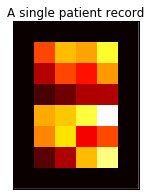

In [134]:
# Plot image that represents a single patient
# These should be simple to interpret
# Once finalised, add these to the clustered plot
# Note: would be interesting to compare plots for different classes

# get dimension of image and add box around it
# cols=int(len(physvars)/rows)
patient_index = 4
cols=int(np.floor(np.sqrt(len(physvars))))
rows=int(np.ceil(len(physvars)/np.float(cols)))
dims=(rows+2,cols+2) 

physvec=np.zeros(cols*rows)
physvec[:len(physvars)] = phys[physvars].iloc[patient_index].values
physbox[1:-1,1:-1]=physvec.reshape((dims[0]-2,dims[1]-2))

print physbox
plt.figure(figsize=(3, 3))
plt.imshow(physbox,cmap="hot",interpolation="none")
plt.xticks([])
plt.yticks([])
plt.title('A single patient record')

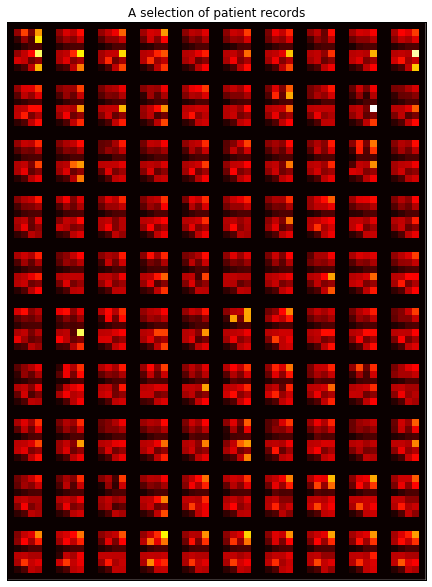

In [128]:
# Plot a grid of images each of which represents a distinct patient
n_img_per_row = 10
img = np.zeros((dims[0] * n_img_per_row, dims[1] * n_img_per_row))
physbox=np.zeros([dims[0],dims[1]])
physvec=np.zeros(cols*rows)
for i in range(n_img_per_row):
    ix = dims[0] * i
    for j in range(n_img_per_row):
        iy = dims[1] * j
        physvec[:len(physvars)]=phys[physvars].iloc[i * n_img_per_row + j].values
        # pad if necessary
        physbox[1:-1,1:-1]=physvec.reshape((dims[0]-2,dims[1]-2))
        img[ix:ix + dims[0], iy:iy + dims[1]] = physbox

plt.figure(figsize=(10, 10))
plt.imshow(img,cmap="hot",interpolation="none")
plt.xticks([])
plt.yticks([])
plt.title('A selection of patient records')

([], <a list of 0 Text yticklabel objects>)

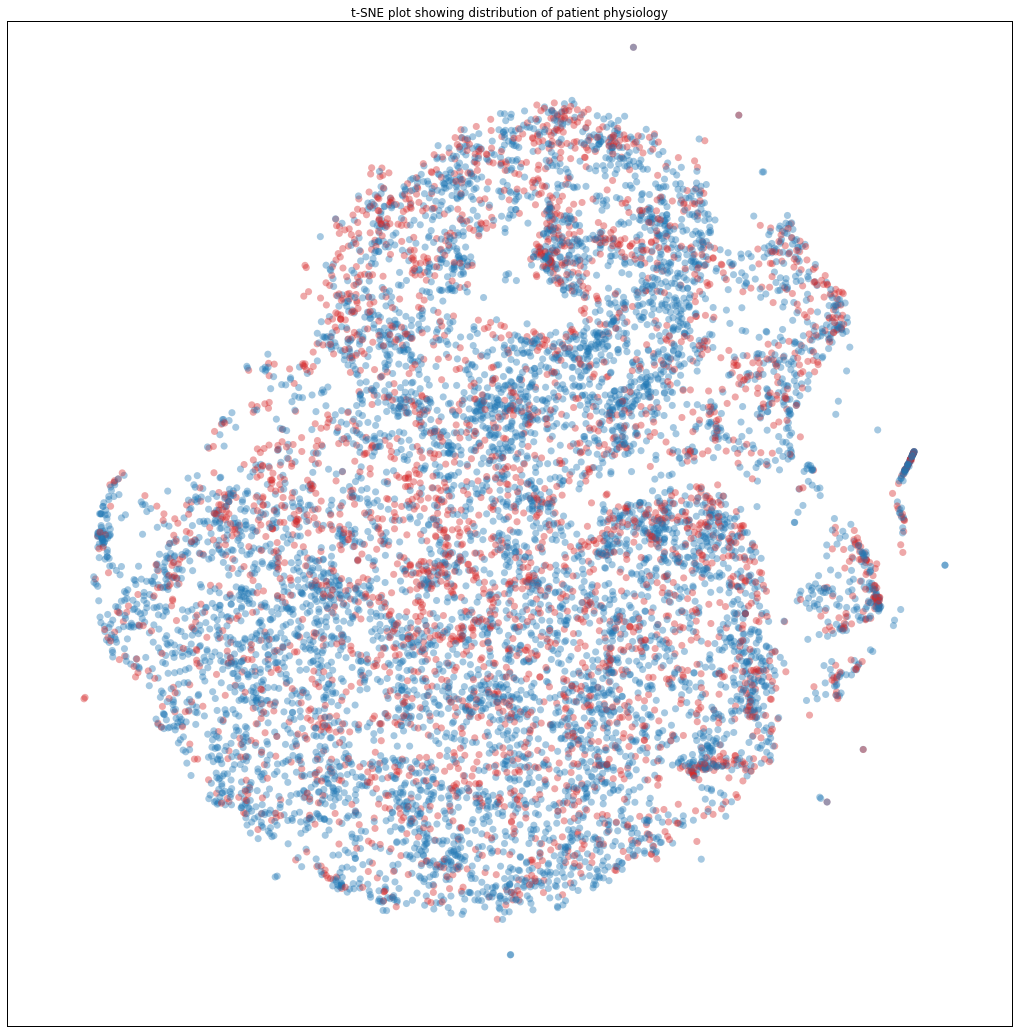

In [204]:
# set colours for plot
# "Tableau 20" colors as RGB. 
# NB: SHOULD PLOT IMAGE OF DATA TO SEE IF PATTERN...
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

# scatter plot
fig, ax = plt.subplots(figsize=(18, 18))
ax.axis([-10, 10, -10, 10])
col = np.array(tableau20)[[phys.label]]
ax.scatter(phys['X_tsne1'], phys['X_tsne2'], 
            facecolor=col, edgecolor='None', marker='o', s=50,cmap=plt.cm.get_cmap("jet", 10),
            alpha=0.4)

plt.title('t-SNE plot showing distribution of patient physiology')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

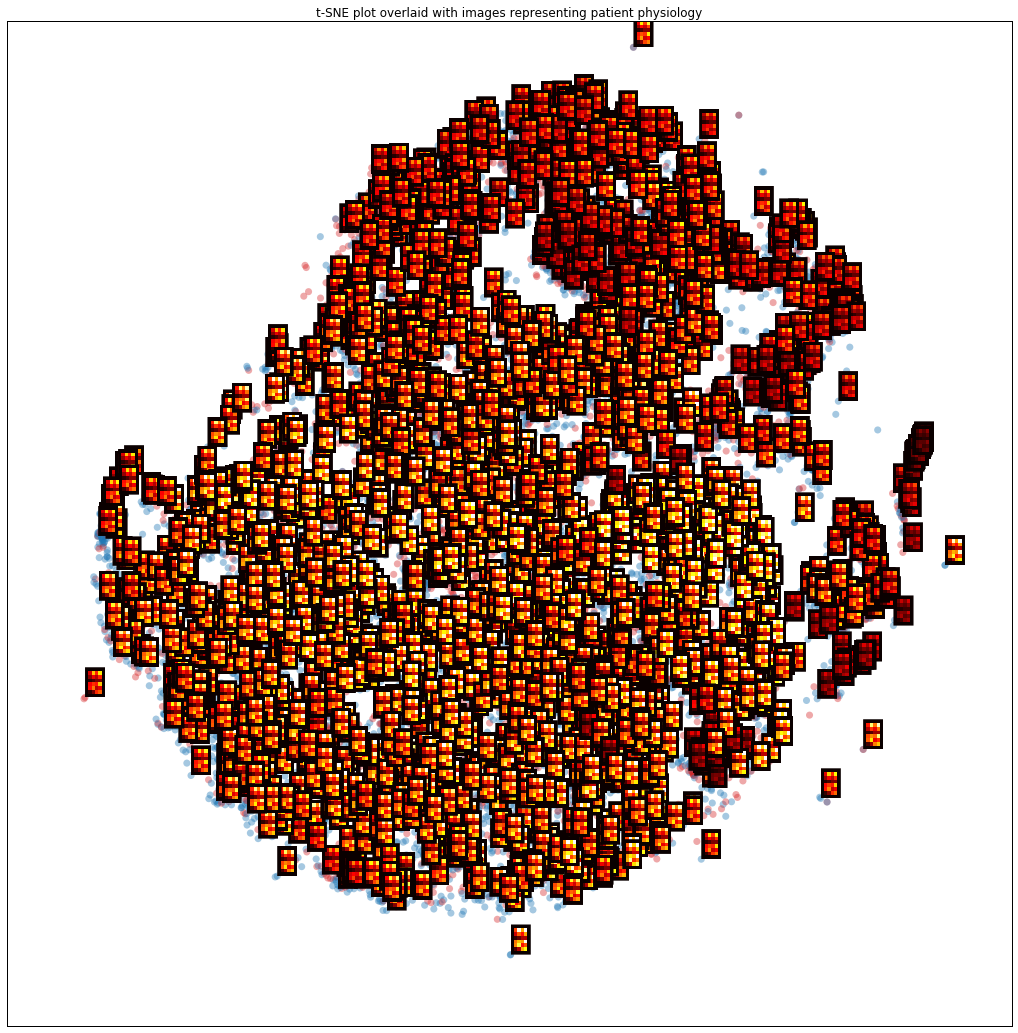

In [207]:
# As before, but overlay images

# scatter plot
fig, ax = plt.subplots(figsize=(18, 18))
ax.axis([-10, 10, -10, 10])
col = np.array(tableau20)[[phys.label]]
ax.scatter(phys['X_tsne1'], phys['X_tsne2'], 
            facecolor=col, edgecolor='None', marker='o', s=50,cmap=plt.cm.get_cmap("jet", 10),
            alpha=0.4,zorder=1)

# overlay images
cols=int(np.floor(np.sqrt(len(physvars))))
rows=int(np.ceil(len(physvars)/np.float(cols)))
dims=(rows+2,cols+2) 
physvec=np.zeros(cols*rows)

for i in range(0,len(phys.index)):
    if i%4==0:
        x=phys['X_tsne1'].iloc[i]
        y=phys['X_tsne2'].iloc[i]
        physvec[:len(physvars)] = phys[physvars].iloc[i].values
        # physvec = physvec/1000 # scale
        physbox[1:-1,1:-1]=physvec.reshape((dims[0]-2,dims[1]-2))
        ax.imshow(physbox,extent=[x,x+cols/10.,y,y+rows/10.],zorder=2,
                  cmap="hot",interpolation="none")

plt.title('t-SNE plot overlaid with images representing patient physiology')
plt.xticks([])
plt.yticks([])